## 1. Import required Libraries

In [32]:
# <<insert yout code here>>
import os 
import numpy as np
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from cleanlab.filter import find_label_issues
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt

## 2. Loading the Data

In [33]:
# <<insert yout code here>>
image_dir = './Images'

labels = []
data = []

allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
img_size = (150, 150)   

for label in os.listdir(image_dir):
    subfolder_path = os.path.join(image_dir, label)

    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            if any(image_file.lower().endswith(ext) for ext in allowed_extensions):
                try: 
                    image = load_img(image_path, color_mode='rgb', target_size=img_size)
                    image = np.array(image) / 255.0

                    labels.append(int(label[-1]) -1)
                    data.append(image)
                
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")


X_all = np.array(data)
y_all = np.array(labels)


print("Loaded images:", X_all.shape)
print("Loaded labels:", y_all.shape)
print("First 5 images in X_all:\n", X_all[:5])
print("First 5 labels in y_all:\n", y_all[:5])

Loaded images: (8538, 150, 150, 3)
Loaded labels: (8538,)
First 5 images in X_all:
 [[[[0.46666667 0.38431373 0.27058824]
   [0.49019608 0.40784314 0.29411765]
   [0.49019608 0.40784314 0.30196078]
   ...
   [0.58823529 0.57647059 0.55686275]
   [0.58431373 0.57254902 0.55294118]
   [0.58039216 0.56862745 0.54901961]]

  [[0.46666667 0.38431373 0.27058824]
   [0.48235294 0.4        0.28627451]
   [0.49019608 0.40784314 0.30196078]
   ...
   [0.58823529 0.57647059 0.55686275]
   [0.58431373 0.57254902 0.55294118]
   [0.58039216 0.56862745 0.54901961]]

  [[0.45490196 0.37254902 0.26666667]
   [0.46666667 0.38431373 0.27843137]
   [0.47843137 0.39607843 0.29019608]
   ...
   [0.58039216 0.56862745 0.54901961]
   [0.57254902 0.56078431 0.54117647]
   [0.56862745 0.55686275 0.5372549 ]]

  ...

  [[0.66666667 0.6627451  0.64313725]
   [0.67058824 0.66666667 0.64705882]
   [0.6745098  0.67058824 0.65098039]
   ...
   [0.70980392 0.71372549 0.69019608]
   [0.70980392 0.71372549 0.69019608]
 

## 3. Data Labelling Errors

In [34]:
# <<insert yout code here>>
# Temp model for cleanlab
def temp_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [35]:
# cross validation
num_classes = len(np.unique(y_all))

pred_probs = np.zeros((len(X_all), num_classes))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X_all):
    model = temp_model(num_classes)
    history = model.fit(
        X_all[train_idx],
        y_all[train_idx],
        epochs=5,
        batch_size=16, 
        validation_data=(X_all[val_idx], y_all[val_idx]),
        verbose=1 
    )

    val_loss, val_acc = model.evaluate(X_all[val_idx], y_all[val_idx], verbose=0)
    accuracies.append(val_acc)
    print(f"Fold {fold}/5 - Val Accuracy: {val_acc:.2%}")

    pred_probs[val_idx] = model.predict(X_all[val_idx], verbose=0)
    fold += 1


avg_acc = np.mean(accuracies)
print(f"\nAverage Model Accuracy: {avg_acc:.2%}")
print("Cross-validation complete!")


Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.3782 - loss: 1.6802 - val_accuracy: 0.4409 - val_loss: 1.5943
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6324 - loss: 1.0228 - val_accuracy: 0.4971 - val_loss: 1.5239
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7807 - loss: 0.6561 - val_accuracy: 0.5896 - val_loss: 1.2749
Epoch 4/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8688 - loss: 0.4034 - val_accuracy: 0.6077 - val_loss: 1.4345
Epoch 5/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9182 - loss: 0.2579 - val_accuracy: 0.6107 - val_loss: 1.5654
Fold 1/5 - Val Accuracy: 61.07%
Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3682 - loss: 1.6924 - val_accuracy: 0.4157 - val_loss: 1.6902
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.6176 - loss: 1.0596 - val_accuracy: 0.5392 - val_loss: 1.3481
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 

In [36]:
# Identify label issues using Cleanlab
label_issues = find_label_issues(
    labels=y_all,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)

print("Number of suspected label errors:", len(label_issues))
label_issues[:20]


Number of suspected label errors: 2456


array([4390, 5813, 7736, 6765, 8098, 8500, 2944, 1204, 1559, 7122, 2412,
       4446, 7797, 7984, 1878, 2758, 2174, 4461, 5613, 3039])

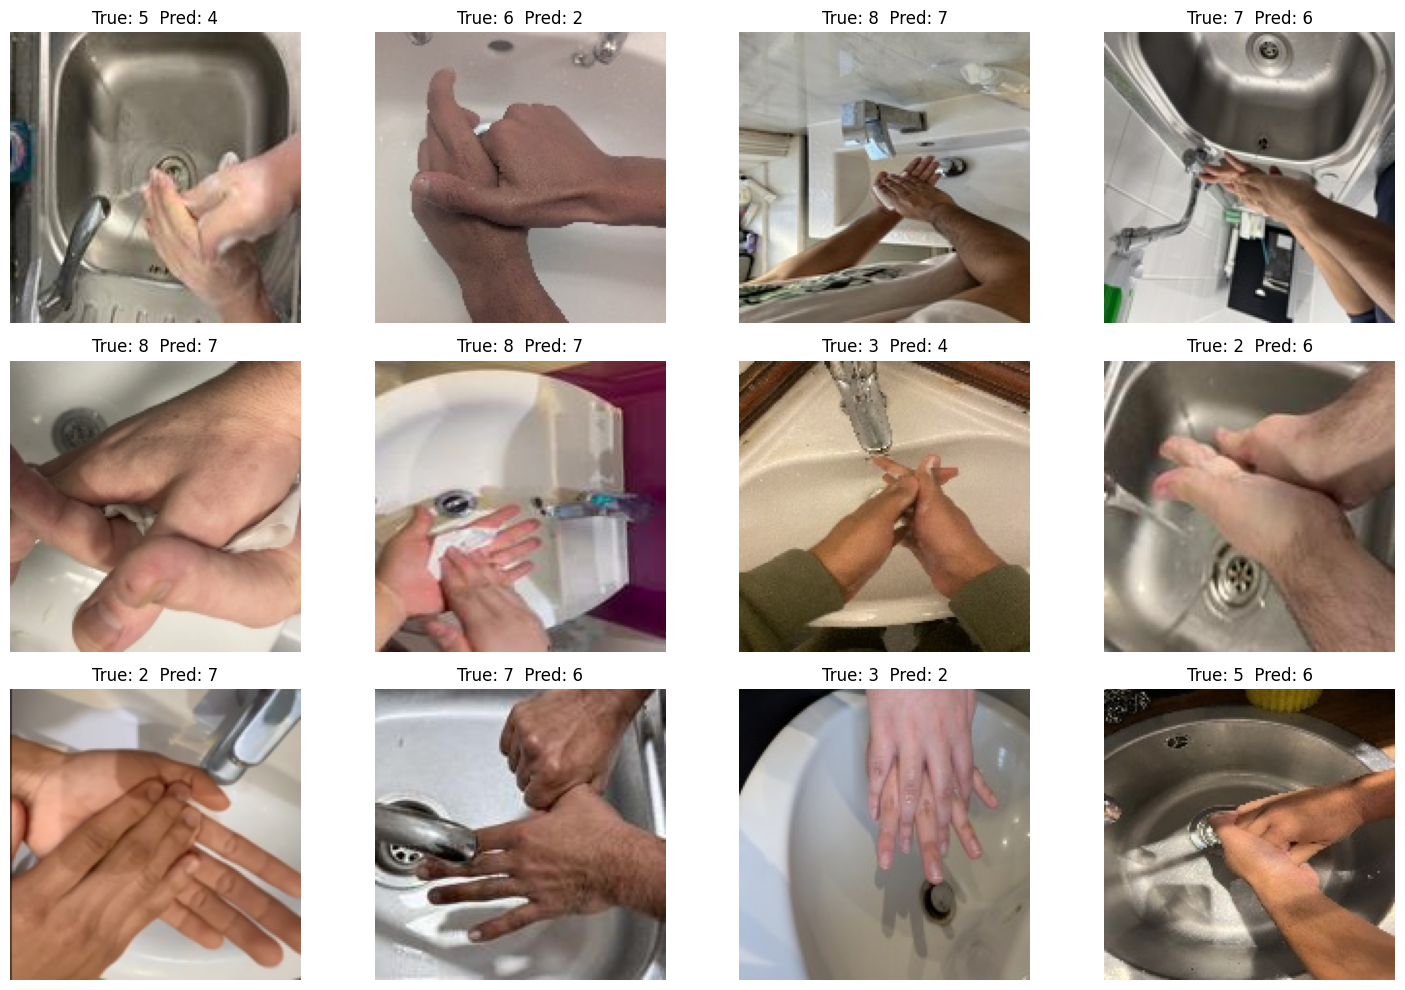

In [37]:
def show_issues(indices, n=12):
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(3,4,i+1)
        plt.imshow(X_all[idx])
        plt.axis('off')

        true_lbl = y_all[idx] + 1
        pred_lbl = np.argmax(pred_probs[idx]) + 1

        plt.title(f"True: {true_lbl}  Pred: {pred_lbl}")

    plt.tight_layout()
    plt.show()

show_issues(label_issues)


In [38]:
# Deleting the skewed images
X_clean = np.delete(X_all, label_issues, axis=0)
y_clean = np.delete(y_all, label_issues, axis=0)

print(f"Original size: {len(X_all)}")
print(f"New size: {len(X_clean)}")

Original size: 8538
New size: 6082


In [39]:
# count samples per class
class_counts = Counter(y_clean)

for cls in sorted(class_counts.keys()):
    print(f"Stage {cls+1}: {class_counts[cls]}")


Stage 1: 914
Stage 2: 620
Stage 3: 597
Stage 4: 780
Stage 5: 700
Stage 6: 748
Stage 7: 863
Stage 8: 860


## Label errors:


<ol>
  <li>The method used</li>
  For identifying label issues, I used Cleanlab’s self-confidence method. Cleanlab works by comparing the model’s predicted probabilities with the provided labels and highlighting the images the model is least confident about.

  I tried several different modelling approaches, including both traditional ML and neural networks, from pretrained models to building one from scratch however the highest accuracy I could achieve was around 62%, This suggested that the main problem wasn’t the choice of model but the data itself, the low accuracy inferes that there are many mislabled images which naturally lowers the models accuracy additionally many images are difficult to distinguish after viusaly confirming, even for a trained model. Because of this, instead of relying on Cleanlab to identify exact label mistakes, which requires a highly accurate model, I used it to detect ambiguous or unclear images. These are the samples the model consistently struggled with, and removing them helps improve overall data quality.

  <li>Explain what kind of errors you found in the dataset.</li>
  When I reviewed the top 20 lowest-confidence images, there was a mix of issues. Some genuinely had incorrect labels, but many were correctly labelled and the model’s prediction was wrong. This happened because the model’s accuracy was relatively low, so the probability scores Cleanlab relied on weren’t strong enough to clearly separate “bad labels” from “bad predictions.”

  A lot of these images were also simply unclear or ambiguous, similar stages, awkward angles, or low-quality samples that would confuse both the model and a human. So overall, the errors were a blend of real label mistakes and images the model couldn’t confidently classify, mainly due to the dataset’s ambiguity rather than the model itself.
  
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <887></li>
  <li>Stage 2: <587></li>
  <li>Stage 3: <683></li>
  <li>Stage 4: <785></li>
  <li>Stage 5: <680></li>
  <li>Stage 6: <770></li>
  <li>Stage 7: <762></li>
  <li>Stage 8: <889></li>
</ol>

## 4. Pre-process the Dataset

In [40]:
# <<insert yout code here>>
# normalise the pixel values
# X_clean = X_clean.astype('float32') / 255.0
# print(f"X_clean.shape: {X_clean.shape}, y_clean.shape: {y_clean.shape}")
# print("Normalised data:", X_clean[0])

## 5. Split the data
<br>

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [41]:
# <<insert yout code here>>
X_train, X_temp, y_train, y_temp = train_test_split(
    X_clean, y_clean, test_size=0.30, random_state=42, stratify=y_clean
)

# Split 2: validation (15%) and test (15%) from the remaining 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (4257, 150, 150, 3)
Validation set: (912, 150, 150, 3)
Test set: (913, 150, 150, 3)


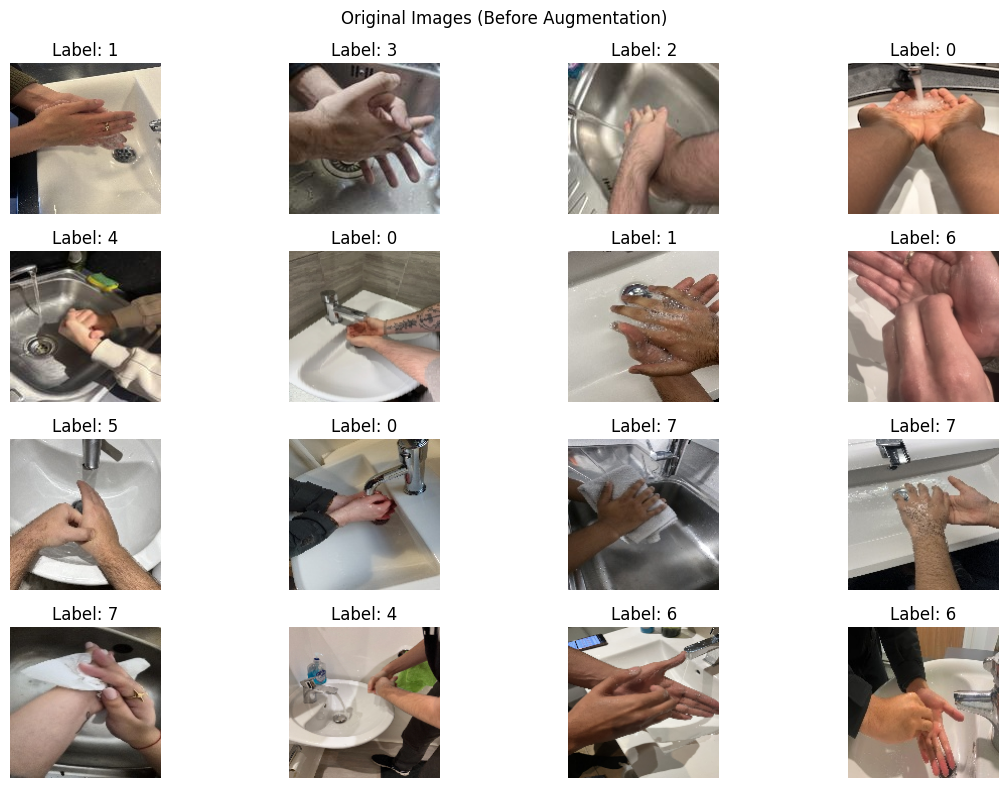

In [42]:
plt.figure(figsize=(12,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Original Images (Before Augmentation)")
plt.tight_layout()
plt.show()

In [64]:
# Data augmentation
train_aug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.05,
    horizontal_flip=True
)


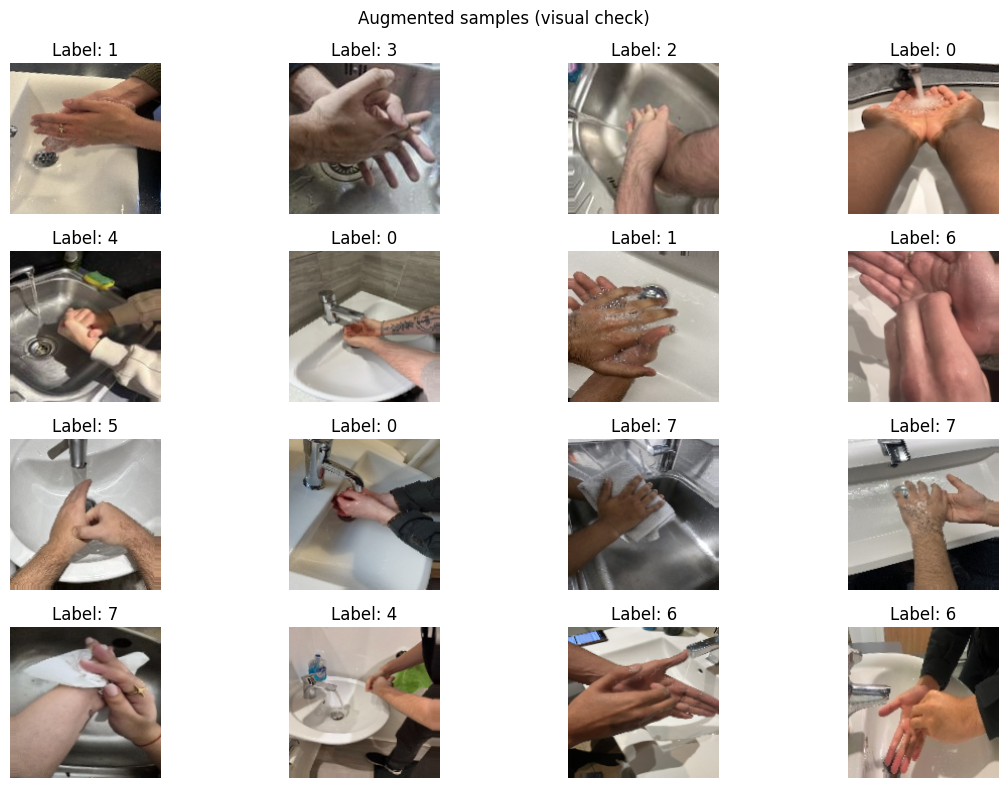

In [65]:
batch = next(train_aug.flow(X_train[:16], y_train[:16], batch_size=16, shuffle=False))

aug_images = batch[0]  # images
aug_labels = batch[1]  # labels

plt.figure(figsize=(12,8))
for i in range(len(aug_images)):
    plt.subplot(4,4,i+1)
    plt.imshow(aug_images[i])
    plt.title(f"Label: {aug_labels[i]}")
    plt.axis('off')
plt.suptitle("Augmented samples (visual check)")
plt.tight_layout()
plt.show()

## Data Preprocessing
As I already handled the resizing (to 150x150) during the loading phase, the only direct transformation needed here was normalising the pixel values to a range of 0 to 1. This is a standard step that helps the neural network calculate weights more efficiently and converge faster. For the data split, I chose a ratio of 70% Training, 15% Validation, and 15% Testing. I used stratified sampling to ensure that the balance of the 8 handwashing stages remains consistent across all three sets, so the test results are reliable and not biased by uneven classes.

One major challenge I had to address here was the reduction in dataset size. Since I used Cleanlab to remove the ambiguous and noisy samples to improve quality, I lost over 2,000 images. To prevent the model from overfitting on this smaller dataset, I implemented Data Augmentation (rotating, flipping, and shifting) on the training set. This helps compensate for the data loss and forces the model to learn robust features, like the shape of the hands—rather than just memorising specific pixels. Data augmentation is only applied to the training data, the validation and testing data was kept the same. 

## 6. Model Implementation

In [161]:
# <<insert yout code here>>
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

number_of_classes = len(np.unique(y_clean))

# the baseline model
def baseline_model(num_classes):
    model = Sequential([
        # conv layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),

        # conv layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # conv layer 3
        Conv2D(64, (3, 3), activation='relu'),

        # fully connected layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# This is the model that I will tweak to optimise the performance form the baseline
def optimised_model(num_classes):
    model = Sequential([
        # Conv block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 4
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv2D(512, (3, 3), padding='same', activation='relu'),
        # BatchNormalization(),
        # MaxPooling2D(2, 2),
        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),

        # Dense(128, activation='relu'),
        # Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [162]:
base_model = baseline_model(number_of_classes)
opt_model = optimised_model(number_of_classes)

In [159]:
# training the base model
base_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))
# Evaluate the model on test data
test_loss, test_acc = base_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1557 - loss: 2.0816 - val_accuracy: 0.1579 - val_loss: 2.0533
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.2145 - loss: 2.0101 - val_accuracy: 0.1963 - val_loss: 2.0747
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.3662 - loss: 1.7122 - val_accuracy: 0.2182 - val_loss: 2.1257
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.6117 - loss: 1.0994 - val_accuracy: 0.2445 - val_loss: 2.9161
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.8332 - loss: 0.5127 - val_accuracy: 0.2390 - val_loss: 4.6768
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.9316 - loss: 0.2277 - val_accuracy: 0.2511 - val_loss: 5.9843
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9774 - loss: 0.1121 - val_accuracy: 0.2588 - val_loss: 7.9576
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.9918 - loss: 0.0390 - 

In [163]:
# training optimised model with augmentation
opt_model.fit(train_aug.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_val, y_val))
test_loss, test_acc = opt_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 360ms/step - accuracy: 0.1759 - loss: 2.8343 - val_accuracy: 0.1250 - val_loss: 3.9802
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.2239 - loss: 2.5210 - val_accuracy: 0.1294 - val_loss: 4.5181
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 355ms/step - accuracy: 0.2544 - loss: 2.4548 - val_accuracy: 0.1634 - val_loss: 3.1732
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - accuracy: 0.2741 - loss: 2.4142 - val_accuracy: 0.2610 - val_loss: 2.4541
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.3152 - loss: 2.3222 - val_accuracy: 0.3202 - val_loss: 2.3087
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.3359 - loss: 2.2628 - val_accuracy: 0.3279 - val_loss: 2.2855
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.3399 - loss: 2.2143 - val_accuracy: 0.3476 - val_loss: 2.2543
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 357ms/step - accuracy: 0.3789 - loss: 2

In [169]:
# converting data back to original scale for efficientnetb0
X_train_eff = X_train * 255.0
X_val_eff = X_val * 255.0
X_test_eff = X_test * 255.0

In [200]:
# Tranfer Learning with EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

def TransferLearningModel(num_classes, unfreeze_depth):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=(150, 150, 3), 
                                                      include_top=False, 
                                                      weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn
    base_model.trainable = True
    if unfreeze_depth != 'all':
        for layer in base_model.layers[:-unfreeze_depth]:
            layer.trainable = False
    
    # head of the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # compile the model
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

eff_model = TransferLearningModel(number_of_classes, 70)

total_params = eff_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in eff_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters:    {non_trainable_params:,}")


Total Parameters:     4,411,435
Trainable Parameters: 3,424,196
Frozen Parameters:    987,239


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-7, 
    verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=6, 
    restore_best_weights=True, 
    verbose=1
)

# Training the transfer learning model
history = eff_model.fit(train_aug.flow(X_train_eff, y_train, batch_size=16), 
                        epochs=30, 
                        validation_data=(X_val_eff, y_val),
                        callbacks=[lr_scheduler, early_stopping])

test_loss, test_acc = eff_model.evaluate(X_test_eff, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}") 

Epoch 1/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.2084 - loss: 2.6273 - val_accuracy: 0.4375 - val_loss: 2.2238 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.4141 - loss: 2.1616 - val_accuracy: 0.5976 - val_loss: 1.7107 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.5624 - loss: 1.7894 - val_accuracy: 0.6886 - val_loss: 1.4559 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.6676 - loss: 1.5291 - val_accuracy: 0.7434 - val_loss: 1.3039 - learning_rate: 1.0000e-04
Epoch 5/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.7106 - loss: 1.3909 - val_accuracy: 0.7434 - val_loss: 1.2431 - learning_rate: 1.0000e-04
Epoch 6/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.7700 - loss: 1.2275 - val_accuracy: 0.7664 - val_loss: 1.1919 - learning_rate: 1.0000e-04
Epoch 7/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 35s 13

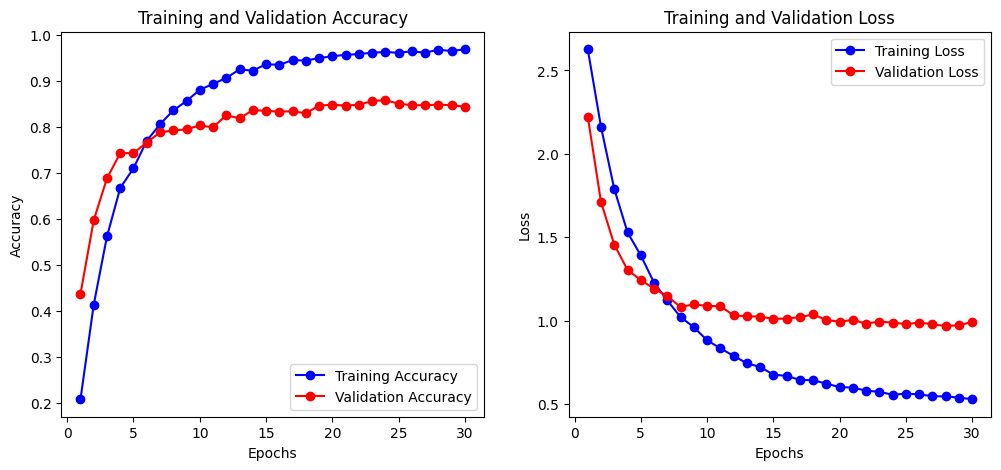

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy') # 'bo-' = Blue dots with line
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy') # 'ro-' = Red dots with line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 4. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. Evaluate the Model

In [ ]:
# <<insert yout code here>>

### Training Curves

In [ ]:
# <<insert yout code here>>

### Make Inference
For some unseen data, make predictions using the trained model.

In [ ]:
# <<insert yout code here>>